In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F

# Define the desired amino acid order using 1-letter codes
#desired_order_1letter = ['G', 'P', 'R', 'K', 'N', 'H', 'Q', 'D', 'E', 'W', 'F', 'Y', 'I', 'V', 'L', 'M', 'C', 'T', 'A', 'S']
desired_order_1letter = ['R', 'H', 'K', 'D', 'E', 'N', 'Q', 'S', 'T', 'C', 'G', 'P', 'A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'X']

# Mapping from 3-letter to 1-letter codes
three_to_one = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y',
    'XXX': 'X'
}

# Reverse mapping from 1-letter to 3-letter codes
one_to_three = {v: k for k, v in three_to_one.items()}

def plot_rearranged_heatmap(prob_filename, index, plot_filename=None, PATH_DIR_PRED = '../output/prediction/'):
    """
    Plots a heatmap of the probabilities with amino acids rearranged according to desired_order_1letter.
    
    Args:
        prob_filename (str): The filename of the .npz file containing the probabilities.
        index (int): The index of the structure to plot.
        plot_filename (str, optional): If provided, saves the plot to this file.
    """
    # Extract and transpose the data for correct orientation in the heatmap
    path_file = f"{PATH_DIR_PRED}{prob_filename}"
    probs = np.load(path_file)
    try:
        data = probs[f'entry_{index}_probabilities'].T  # shape: (amino acids, positions)
    except KeyError:
        raise ValueError(f"Index {index} not found in the probabilities file. Available keys: {list(probs.keys())}")
    aa_names = np.array(probs['aa_index_to_name'])  # 3-letter codes

    aa_1letter = [three_to_one.get(aa, 'X') for aa in aa_names]

    # Create a mapping from 1-letter code to index in the original data
    aa_to_index = {aa: i for i, aa in enumerate(aa_1letter)}

    # Get the new order of indices based on desired_order_1letter
    new_order_indices = [aa_to_index[aa] for aa in desired_order_1letter if aa in aa_to_index]

    # Rearrange the data and labels
    rearranged_probs = data[new_order_indices, :]
    rearranged_labels = [one_to_three[aa] for aa in desired_order_1letter if aa in aa_to_index]

    # Remap true and predicted indices
    original_to_new = {orig: new_order_indices.index(orig) for orig in new_order_indices}
    true_indices = [original_to_new[i] for i in probs[f'entry_{index}_true_indices'] if i in original_to_new]
    predicted_indices = [original_to_new[i] for i in probs[f'entry_{index}_predicted_indices'] if i in original_to_new]

    # Create the heatmap
    plt.figure(figsize=(24, 8))
    ax = sns.heatmap(
        rearranged_probs,
        cmap='flare',
        annot=False,
        fmt=".2f",
        cbar_kws={'label': 'Probability'}
    )

    # calculate the accuracy
    accuracy = np.mean(np.array(true_indices) == np.array(predicted_indices))

    # also calculate categorical cross entropy and write it on the title
    # make sure the shapes are compatible by transposing if necessary
    
    
    if rearranged_probs.shape[0] == 21:  # Ensure we have the right shape
        true_labels = F.one_hot(torch.tensor(true_indices), num_classes=21).float()
        pred_probs = torch.tensor(rearranged_probs).T
        ce_loss = F.binary_cross_entropy(pred_probs, true_labels, reduction='mean').item()
    else:
        ce_loss = np.nan

    # Center y-ticks on the bars
    ax.set_yticks(np.arange(len(rearranged_labels)) + 0.5)
    ax.set_yticklabels(rearranged_labels, rotation=0)

    # Add red and blue dots for true and predicted indices
    plt.scatter(np.arange(len(true_indices)) + 0.5, np.array(true_indices) + 0.35, color='blue', s=20, label='True Index', marker='o')
    plt.scatter(np.arange(len(predicted_indices)) + 0.5, np.array(predicted_indices) + 0.65, color='limegreen', s=20, label='Predicted Index', marker='o')

    # Set labels and title
    plt.title(f'Rearranged Heatmap of Probabilities for structure {index} with recovery accuracy: {accuracy:.2f} and CE loss: {ce_loss:.4f}')
    plt.xlabel('Amino Acid Position')
    plt.ylabel('Amino Acid Type')
    # move legend to outside the plot
    
    plt.legend(loc='lower left', bbox_to_anchor=(1.02, 1.02), borderaxespad=0)

    plt.tight_layout()

    if plot_filename:
        plt.savefig(f"intermediates/{plot_filename}")

    # draw a line under the third, fifth, 9th, and 12th rows
    for line in [3, 5, 9, 12]:
        plt.axhline(y=line, color='white', linewidth=3, linestyle='--')
    for line in np.arange(0, data.shape[0], step=1):
        plt.axhline(y=line, color='white', linewidth=0.2, linestyle='-')

    # also add a vertical line at every 5% of the x-axis
    for x in np.arange(0, data.shape[1], step=data.shape[1] // 25):
        plt.axvline(x=x, color='gray', linewidth=0.3, linestyle='-')

    plt.show()


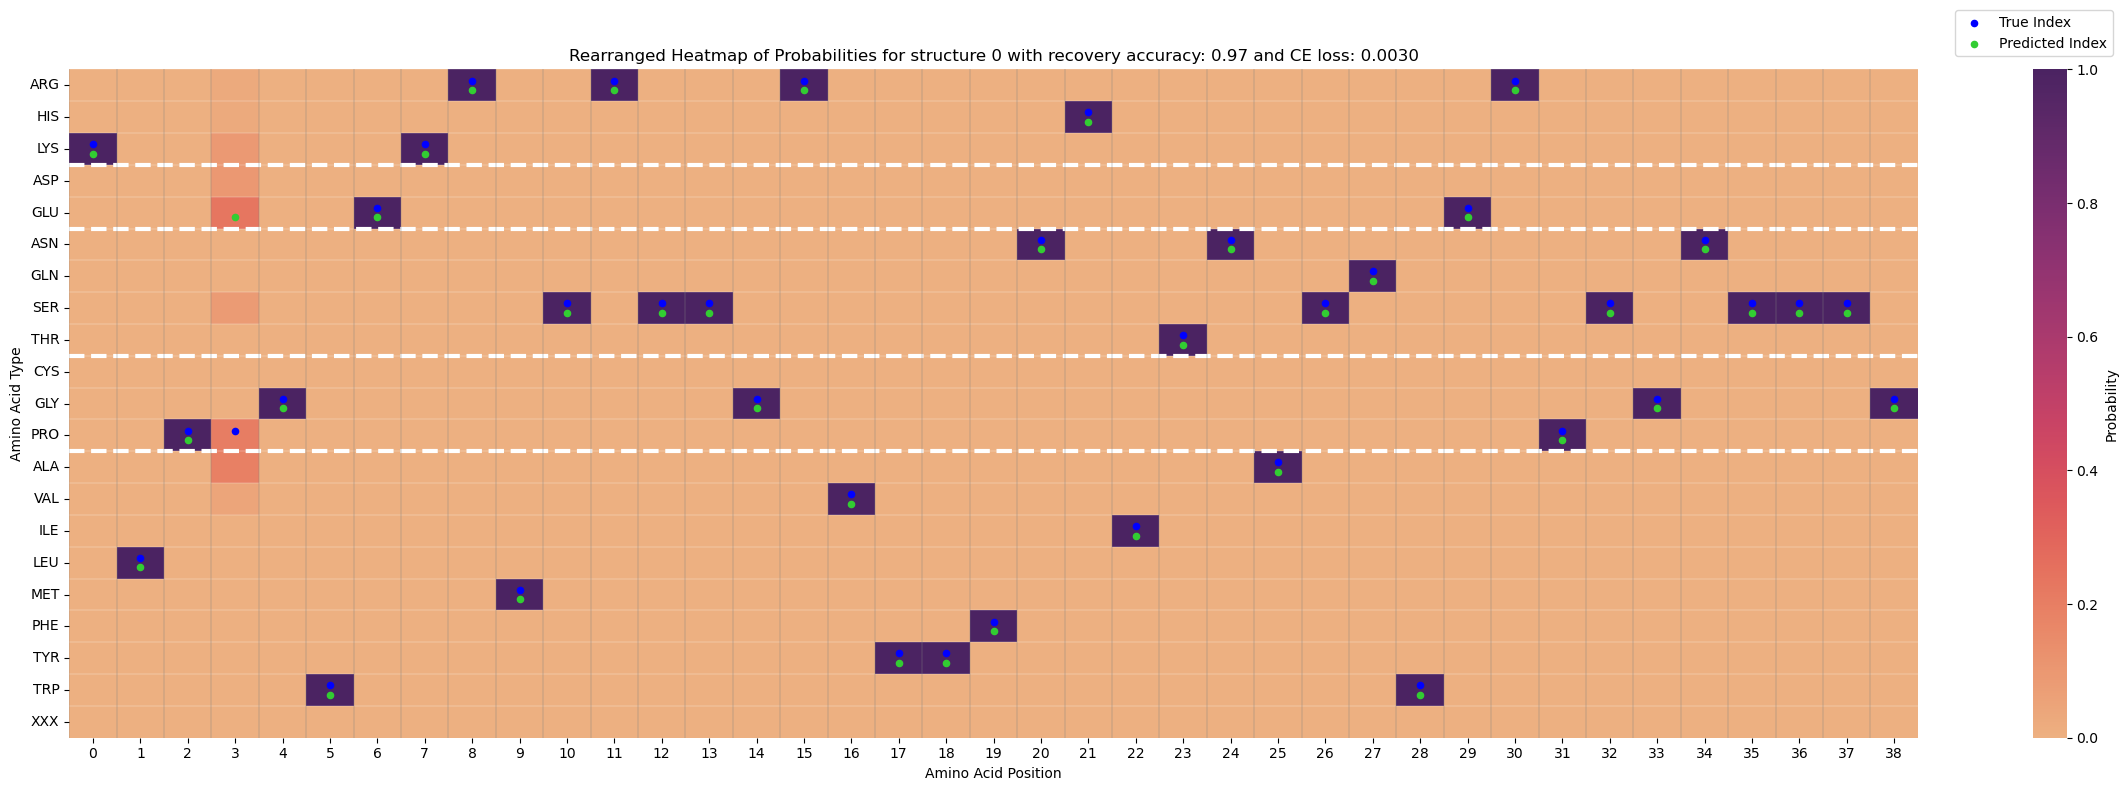

In [4]:
plot_rearranged_heatmap(prob_filename = 'inpainting_results.npz',
plot_filename=None, PATH_DIR_PRED = '../output/inpainting_results/', index=0)

## batch results

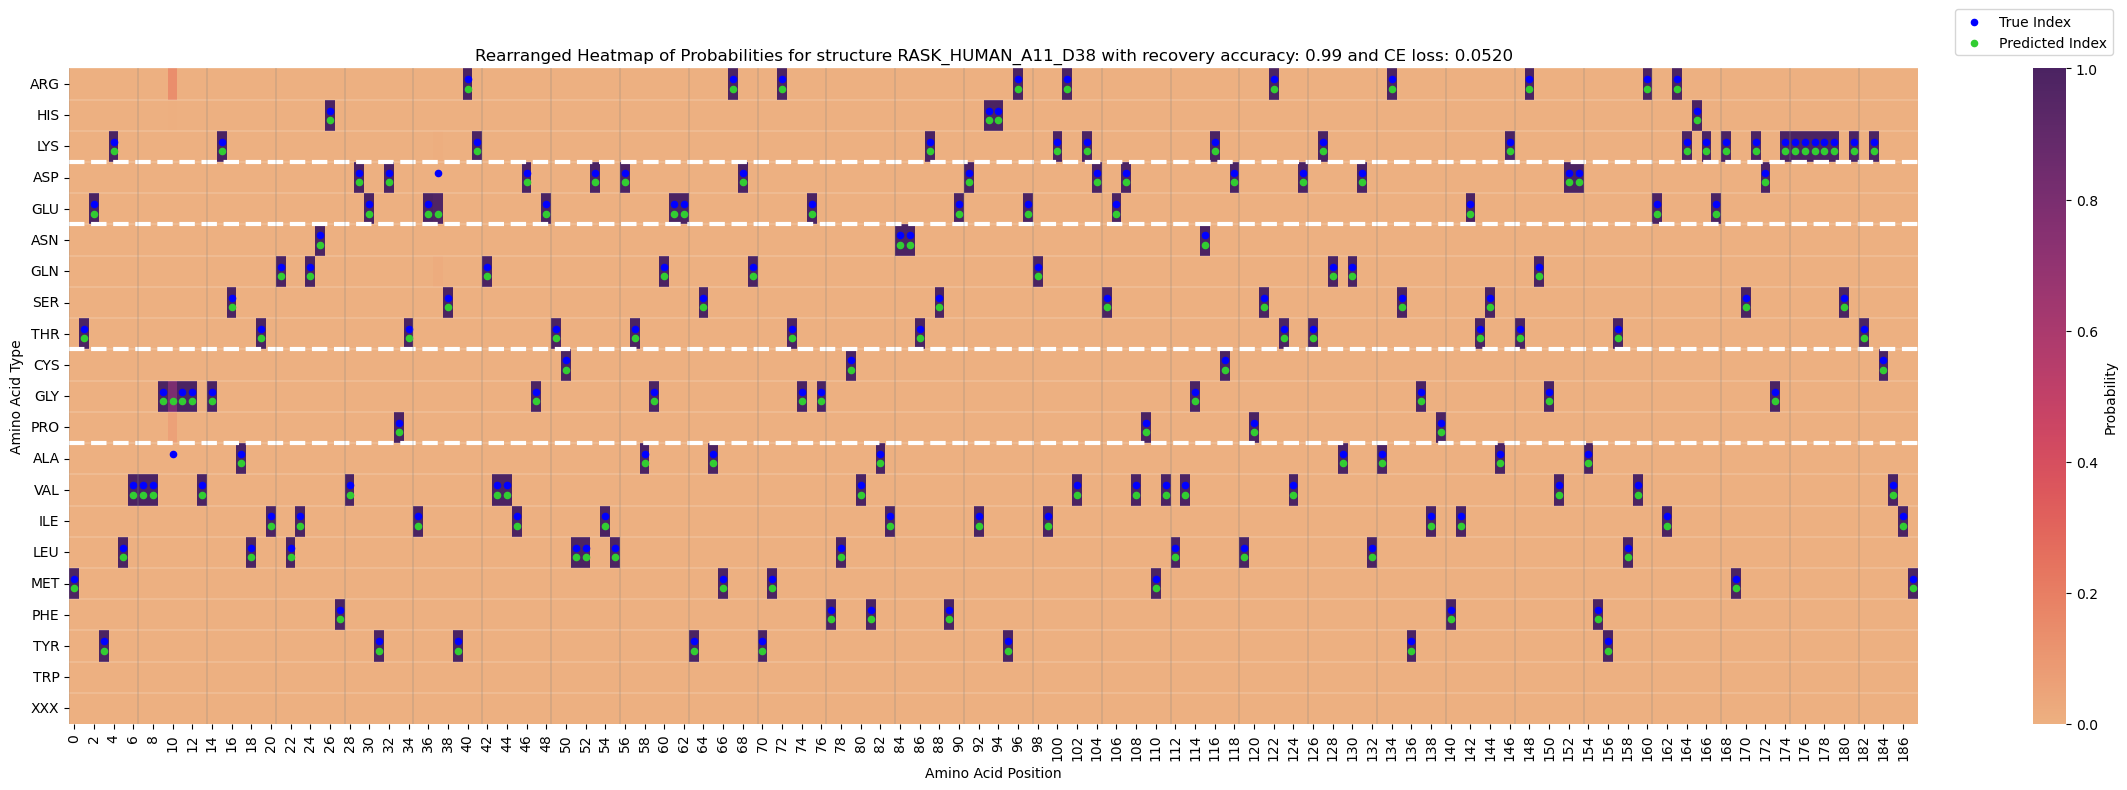

In [15]:
plot_rearranged_heatmap(prob_filename = 'batch_inpainting_results.npz',
plot_filename=None, PATH_DIR_PRED = '../output/inpainting_results/', index="RASK_HUMAN_A11_D38")

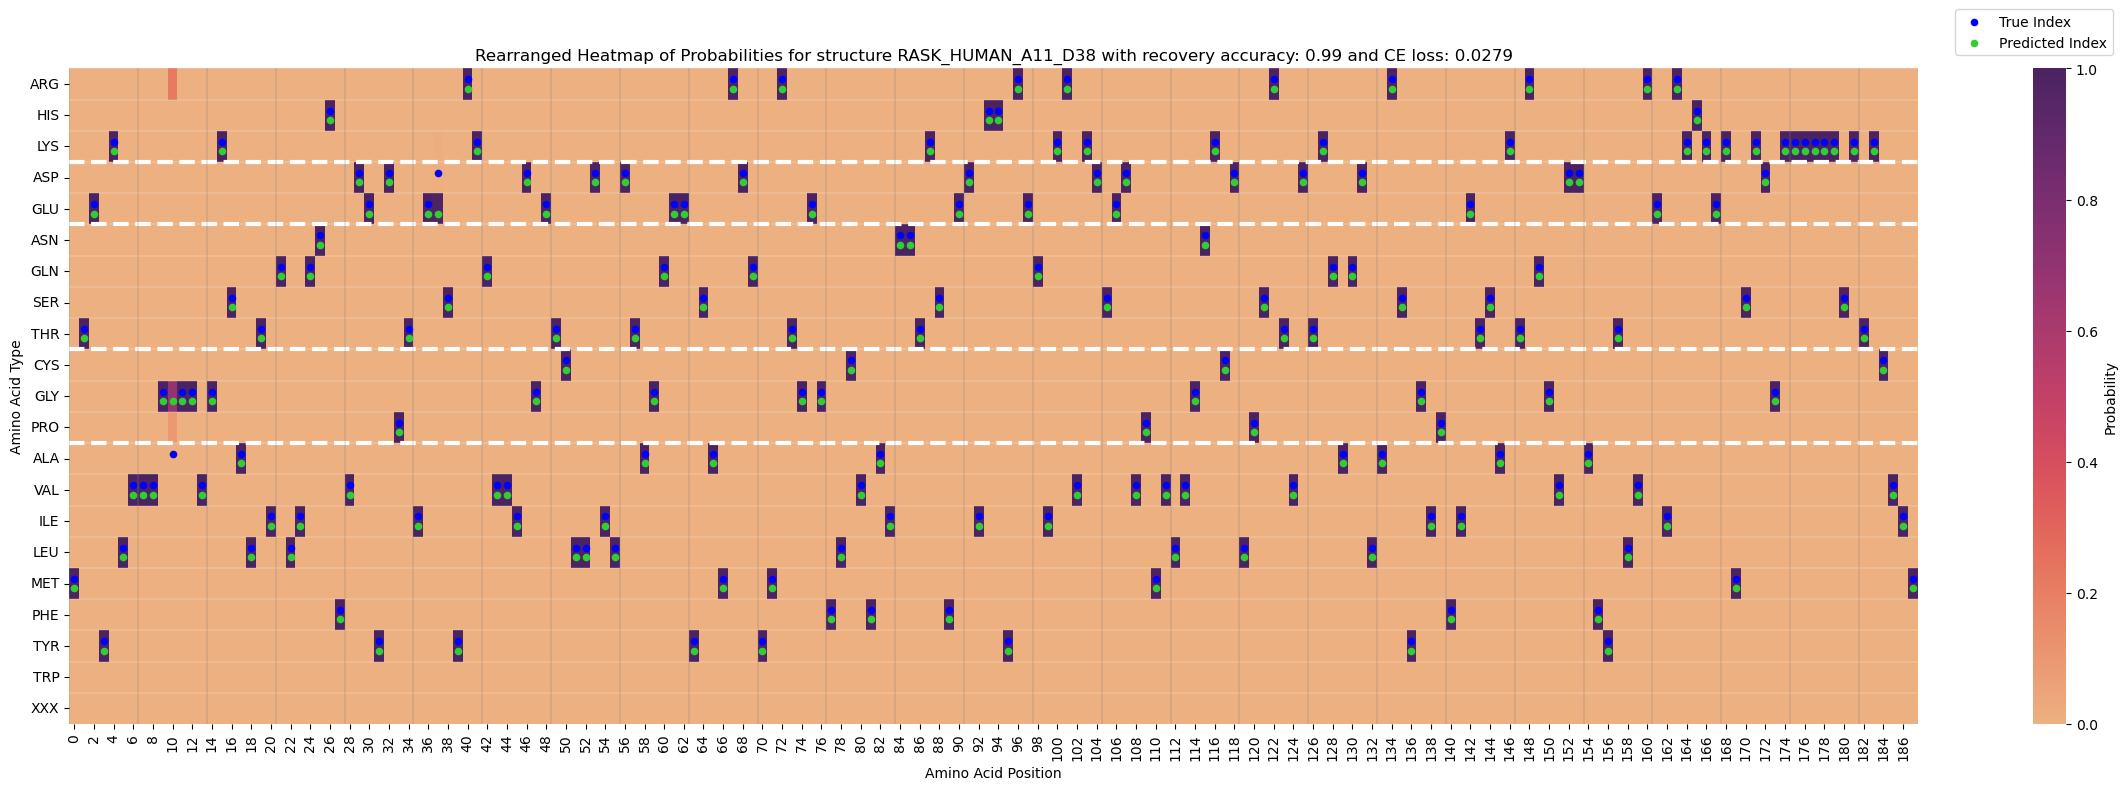

In [16]:
plot_rearranged_heatmap(prob_filename = 'batch_inpainting_results.npz',
plot_filename=None, PATH_DIR_PRED = '../output/inpainting_results/', index="RASK_HUMAN_A11_D38")

In [ ]:
plot_rearranged_heatmap(prob_filename = 'batch_inpainting_results.npz',
plot_filename=None, PATH_DIR_PRED = '../output/inpainting_results/', index="RASK_HUMAN_A11_D38")

In [1]:
import numpy as np

In [9]:
preds = np.load("../output/inpainting_results/inpainting_results.npz")

In [10]:
preds['final_probabilities'][6]

array([3.73236311e-04, 8.24490562e-04, 1.28589847e-04, 4.99560265e-05,
       4.22688347e-04, 1.20969613e-04, 1.88300008e-04, 7.78368092e-04,
       1.61070994e-03, 1.85220840e-03, 1.46777893e-04, 1.08739194e-04,
       1.65526963e-05, 1.59414267e-05, 4.90492348e-05, 2.99101113e-04,
       6.02222455e-04, 9.91537750e-01, 8.33473459e-04, 4.08694032e-05,
       1.19164803e-10], dtype=float32)